## Assignment 4 Code: Tutorials

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

### Multi-Class Text Classification

In [64]:
import csv
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

In [65]:
bbc = pd.read_csv('bbc-text.csv')
bbc.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


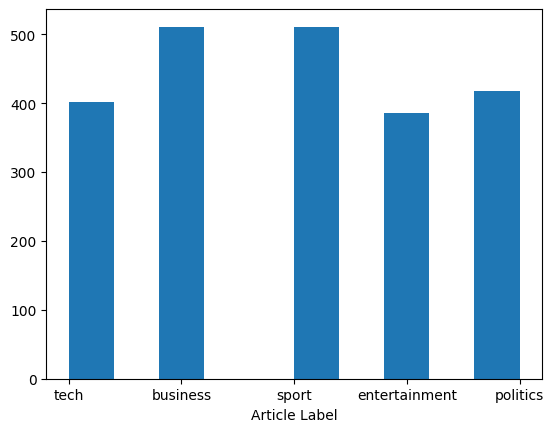

In [66]:
plt.hist(bbc['category']);
plt.xlabel('Article Label');

In [67]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikkipoentis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
# sets hyper-parameters
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

In [69]:
# populates the list of articles and labels from data
# and removes the stopwords
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [70]:
# creates training and validating set
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print("train_articles:", len(train_articles))
print("validation_articles:", len(validation_articles))

train_articles: 1780
validation_articles: 445


In [71]:
# sets tokenization for articles
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# if the word is not already listed in our dictionary, uses <OOV>
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

# converts to sequences: takes each word in the text and replaces it with its 
# corresponding integer value in the dictionary 
train_sequences = tokenizer.texts_to_sequences(train_articles)

# sequence truncation and padding (so its all the same size)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

word_index

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10,
 'could': 11,
 'last': 12,
 'first': 13,
 'time': 14,
 'two': 15,
 'government': 16,
 'world': 17,
 'uk': 18,
 'best': 19,
 'years': 20,
 'make': 21,
 'film': 22,
 'told': 23,
 'made': 24,
 'get': 25,
 'music': 26,
 'game': 27,
 'like': 28,
 'back': 29,
 'many': 30,
 '000': 31,
 'labour': 32,
 'three': 33,
 'well': 34,
 '1': 35,
 'next': 36,
 'bbc': 37,
 'take': 38,
 'set': 39,
 'number': 40,
 'added': 41,
 'way': 42,
 'market': 43,
 '2': 44,
 'company': 45,
 'may': 46,
 'says': 47,
 'election': 48,
 'home': 49,
 'party': 50,
 'good': 51,
 'going': 52,
 'much': 53,
 'work': 54,
 '2004': 55,
 'still': 56,
 'win': 57,
 'show': 58,
 'think': 59,
 'games': 60,
 'go': 61,
 'top': 62,
 'second': 63,
 'million': 64,
 '6': 65,
 'england': 66,
 'firm': 67,
 'since': 68,
 'week': 69,
 'say': 70,
 'play': 71,
 'part': 72,
 'public': 73,
 'use': 74,
 'blair': 75,
 '3': 76,
 'want'

In [72]:
# sets tokenization for labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

label_tokenizer.word_index

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}

In [73]:
# creates model

class_model = Sequential()
# turns the input integer indices into the corresponding word vectors
class_model.add(Embedding(vocab_size, embedding_dim))
class_model.add(Dropout(0.5))
# propagates the input forward and backwards through the LSTM layer and 
# then concatenates the output 
class_model.add(Bidirectional(LSTM(embedding_dim)))
class_model.add(Dense(6, activation='softmax'))

class_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_16 (Dense)            (None, 6)                 774       
                                                                 
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


In [74]:
# compiles model
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
class_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

# trains model
num_epochs = 10
history1 = class_model.fit(train_padded, training_label_seq, 
                     epochs=num_epochs, 
                     validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 11s - loss: 1.6127 - accuracy: 0.2713 - val_loss: 1.4563 - val_accuracy: 0.2944 - 11s/epoch - 197ms/step
Epoch 2/10
56/56 - 5s - loss: 1.0919 - accuracy: 0.6118 - val_loss: 0.7988 - val_accuracy: 0.7775 - 5s/epoch - 91ms/step
Epoch 3/10
56/56 - 7s - loss: 0.5432 - accuracy: 0.8376 - val_loss: 0.5616 - val_accuracy: 0.8494 - 7s/epoch - 121ms/step
Epoch 4/10
56/56 - 6s - loss: 0.3024 - accuracy: 0.9084 - val_loss: 0.4268 - val_accuracy: 0.8764 - 6s/epoch - 112ms/step
Epoch 5/10
56/56 - 5s - loss: 0.1555 - accuracy: 0.9624 - val_loss: 0.2865 - val_accuracy: 0.9034 - 5s/epoch - 90ms/step
Epoch 6/10
56/56 - 5s - loss: 0.1019 - accuracy: 0.9697 - val_loss: 0.2115 - val_accuracy: 0.9416 - 5s/epoch - 91ms/step
Epoch 7/10
56/56 - 5s - loss: 0.0447 - accuracy: 0.9893 - val_loss: 0.1619 - val_accuracy: 0.9528 - 5s/epoch - 85ms/step
Epoch 8/10
56/56 - 5s - loss: 0.1837 - accuracy: 0.9556 - val_loss: 0.3705 - val_accuracy: 0.9169 - 5s/epoch - 87ms/step
Epoch 9/10
56/56 - 5s - los

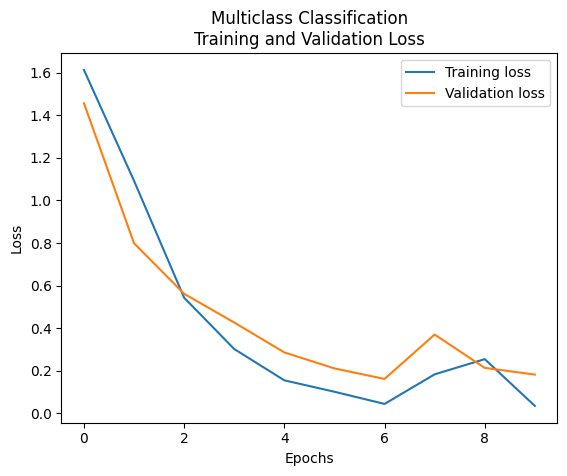

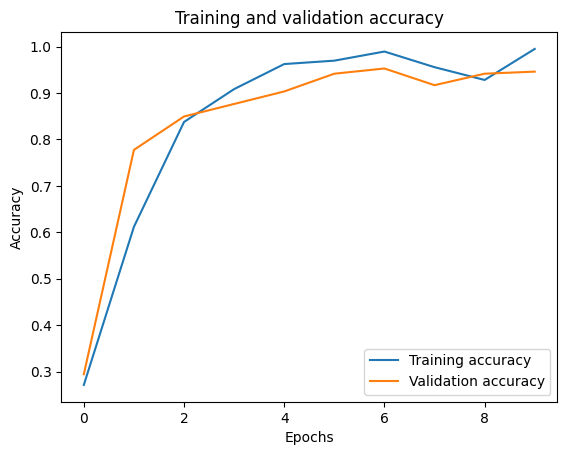

In [75]:
import matplotlib.pyplot as plt

# generates metrics to be graphed 
history1_dict = history1.history
loss_values = history1_dict['loss']
val_loss_values = history1_dict['val_loss']
epochs = range(0, len(loss_values))
acc_values = history1_dict['accuracy']
val_acc_values = history1_dict['val_accuracy'] 

plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Multiclass Classification\nTraining and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()

plt.clf() # Clears the figure
plt.plot(epochs, acc_values, label='Training accuracy')
plt.plot(epochs, val_acc_values, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
# makes predictions part 1 (correct label is politics)
txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break  the bbc s political editor has learned.  andrew marr says mr blair will ask the queen on 4 or 5 april to dissolve parliament at the end of that week. mr blair has so far resisted calls for him to name the day but all parties have stepped up campaigning recently. downing street would not be drawn on the claim  saying election timing was a matter for the prime minister.  a number 10 spokeswoman would only say:  he will announce an election when he wants to announce an election.  the move will signal a frantic week at westminster as the government is likely to try to get key legislation through parliament. the government needs its finance bill  covering the budget plans  to be passed before the commons closes for business at the end of the session on 7 april.  but it will also seek to push through its serious and organised crime bill and id cards bill. mr marr said on wednesday s today programme:  there s almost nobody at a senior level inside the government or in parliament itself who doesn t expect the election to be called on 4 or 5 april.  as soon as the commons is back after the short easter recess  tony blair whips up to the palace  asks the queen to dissolve parliament ... and we re going.  the labour government officially has until june 2006 to hold general election  but in recent years governments have favoured four-year terms."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = class_model.predict(padded)
labels = ['sport', 'business', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

1/1 [==============================] - 1s 597ms/step
[[2.2635455e-04 3.4800202e-03 3.3910519e-03 9.7424477e-01 1.5610320e-02
  3.0475373e-03]]
3
politics


In [77]:
# makes predictions part 1 (correct label is business)
txt = ["call to save manufacturing jobs the trades union congress (tuc) is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies.  the tuc said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year. it calls for better pensions  child care provision and decent wages. the 36-page submission also urges the government to examine support other european countries provide to industry. tuc general secretary brendan barber called for  a commitment to policies that will make a real difference to the lives of working people.    greater investment in childcare strategies and the people delivering that childcare will increases the options available to working parents   he said.  a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the frontline services that this country needs.  he also called for  practical measures  to help pensioners  especially women who he said  are most likely to retire in poverty . the submission also calls for decent wages and training for people working in the manufacturing sector."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = class_model.predict(padded)
labels = ['sport', 'business', 'politics', 'tech', 'entertainment'] 

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)-1])

1/1 [==============================] - 0s 27ms/step
[[0.00371355 0.12754533 0.09450841 0.00450795 0.09576143 0.6739633 ]]
5
entertainment


### Time Series Prediction 

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

tf.random.set_seed(7) # fixes the random seed for reproducibility

In [79]:
df = pd.read_csv('airline-passengers.csv', usecols=[1])
airlines = df.values
airlines = df.astype('float32')
airlines.head()

,Passengers
0,112.0
1,118.0
2,132.0
3,129.0
4,121.0


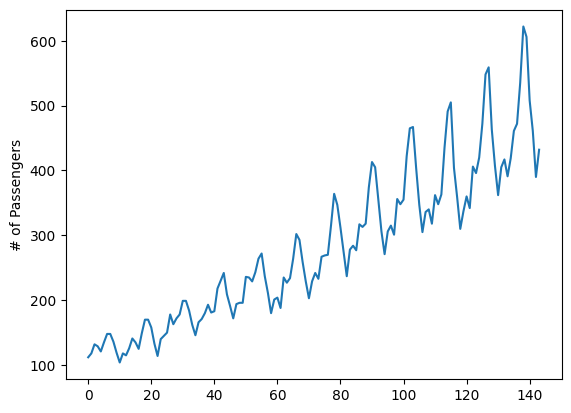

In [80]:
plt.plot(airlines);
plt.ylabel('# of Passengers');

In [81]:
# normalizes the dataset (rescales data to the [0,1] range)
scaler = MinMaxScaler(feature_range=(0,1))
airlines = scaler.fit_transform(airlines)

In [82]:
# splits data into training and testing sets
train_size = int(len(airlines) * 0.67)
test_size = len(airlines) - train_size
train, test = airlines[0:train_size,:], airlines[train_size:len(airlines),:]

print('train_size:', train_size)
print('test_size:', test_size)

train_size: 96
test_size: 48


In [83]:
# dataset needs to be altered so that x = the number of passengers at a given time (t) 
# and y = the number of passengers at the next time (t+1) 
def configure_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### LSTM for Basic Regression

In [84]:
look_back = 1
trainX, trainY = configure_dataset(train, look_back)
testX, testY = configure_dataset(test, look_back)

# the LSTM network expects the input to be structured [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# creates and trains the LSTM network
reg_model = Sequential()
reg_model.add(LSTM(4, input_shape=(1, look_back)))
reg_model.add(Dense(1))
reg_model.compile(loss='mean_squared_error', optimizer='adam')
reg_model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0435 - 2s/epoch - 20ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0222 - 148ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0158 - 151ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0143 - 129ms/epoch - 1ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0134 - 114ms/epoch - 1ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0123 - 105ms/epoch - 1ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0114 - 97ms/epoch - 1ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0104 - 96ms/epoch - 1ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0097 - 85ms/epoch - 901us/step
Epoch 10/100
94/94 - 0s - loss: 0.0086 - 139ms/epoch - 1ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0077 - 129ms/epoch - 1ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0067 - 131ms/epoch - 1ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0059 - 120ms/epoch - 1ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0052 - 132ms/epoch - 1ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0045 - 105ms/epoch - 1ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0039 - 106ms/epoch

In [85]:
# makes predictions
trainPredict = reg_model.predict(trainX)
testPredict = reg_model.predict(testX)

# inverts predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculates root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 2ms/step
Train Score: 22.68 RMSE
Test Score: 49.23 RMSE


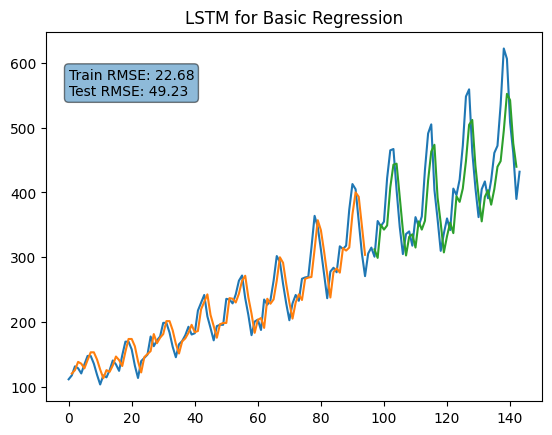

In [86]:
trainRMSE = 'Train RMSE: %.2f' % (trainScore)
testRMSE = 'Test RMSE: %.2f' % (testScore)

# shifts train predictions for plotting
trainPredictPlot = np.empty_like(airlines)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shifts test predictions for plotting
testPredictPlot = np.empty_like(airlines)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(airlines)-1, :] = testPredict

# plots baseline and predictions
plt.plot(scaler.inverse_transform(airlines))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('LSTM for Basic Regression')
props = dict(boxstyle='round', alpha=0.5)
plt.text(x=0, y=550, s=(trainRMSE + '\n' + testRMSE), 
        bbox=props)
plt.show()

#### LSTM for Regression Using the Window Method

In [87]:
look_back2 = 3
train2X, train2Y = configure_dataset(train, look_back2)
test2X, test2Y = configure_dataset(test, look_back2)

# the LSTM network expects the input to be structured [samples, time steps, features]
train2X = np.reshape(train2X, (train2X.shape[0], 1, train2X.shape[1]))
test2X = np.reshape(test2X, (test2X.shape[0], 1, test2X.shape[1]))

# creates and trains the LSTM network
reg2_model = Sequential()
reg2_model.add(LSTM(4, input_shape=(1, look_back2)))
reg2_model.add(Dense(1))
reg2_model.compile(loss='mean_squared_error', optimizer='adam')
reg2_model.fit(train2X, train2Y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
92/92 - 1s - loss: 0.0387 - 1s/epoch - 12ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0157 - 109ms/epoch - 1ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0107 - 95ms/epoch - 1ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0092 - 124ms/epoch - 1ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0079 - 118ms/epoch - 1ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0069 - 105ms/epoch - 1ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0060 - 106ms/epoch - 1ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0052 - 137ms/epoch - 1ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0045 - 120ms/epoch - 1ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0040 - 113ms/epoch - 1ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0038 - 90ms/epoch - 974us/step
Epoch 12/100
92/92 - 0s - loss: 0.0035 - 110ms/epoch - 1ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0034 - 99ms/epoch - 1ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0034 - 102ms/epoch - 1ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0032 - 116ms/epoch - 1ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0031 - 195ms/epoch

In [88]:
# makes predictions
train2Predict = reg2_model.predict(train2X)
test2Predict = reg2_model.predict(test2X)

# inverts predictions
train2Predict = scaler.inverse_transform(train2Predict)
train2Y = scaler.inverse_transform([train2Y])
test2Predict = scaler.inverse_transform(test2Predict)
test2Y = scaler.inverse_transform([test2Y])

# calculates root mean squared error
train2Score = np.sqrt(mean_squared_error(train2Y[0], train2Predict[:,0]))
test2Score = np.sqrt(mean_squared_error(test2Y[0], test2Predict[:,0]))

print('Train Score: %.2f RMSE' % (train2Score))
print('Test Score: %.2f RMSE' % (test2Score))

2/2 [==============================] - 0s 2ms/step
Train Score: 23.04 RMSE
Test Score: 61.81 RMSE


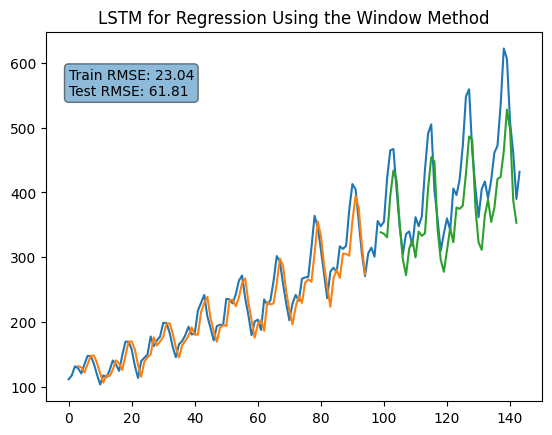

In [89]:
train2RMSE = 'Train RMSE: %.2f' % (train2Score)
test2RMSE = 'Test RMSE: %.2f' % (test2Score)

# shifts train predictions for plotting
train2PredictPlot = np.empty_like(airlines)
train2PredictPlot[:, :] = np.nan
train2PredictPlot[look_back2:len(train2Predict)+look_back2, :] = train2Predict
# shifts test predictions for plotting
test2PredictPlot = np.empty_like(airlines)
test2PredictPlot[:, :] = np.nan
test2PredictPlot[len(train2Predict)+(look_back2*2)+1:len(airlines)-1, :] = test2Predict

# plots baseline and predictions
plt.plot(scaler.inverse_transform(airlines))
plt.plot(train2PredictPlot)
plt.plot(test2PredictPlot)
plt.title('LSTM for Regression Using the Window Method')
props = dict(boxstyle='round', alpha=0.5)
plt.text(x=0, y=550, s=(train2RMSE + '\n' + test2RMSE), 
        bbox=props)
plt.show()

#### LSTM for Regression with Time Steps

In [90]:
look_back3 = 3
train3X, train3Y = configure_dataset(train, look_back3)
test3X, test3Y = configure_dataset(test, look_back3)

# the LSTM network expects the input to be structured [samples, time steps, features]
train3X = np.reshape(train3X, (train3X.shape[0], train3X.shape[1], 1))
test3X = np.reshape(test3X, (test3X.shape[0], test3X.shape[1], 1))

# creates and trains the LSTM network
reg3_model = Sequential()
reg3_model.add(LSTM(4, input_shape=(look_back3, 1)))
reg3_model.add(Dense(1))
reg3_model.compile(loss='mean_squared_error', optimizer='adam')
reg3_model.fit(train3X, train3Y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
92/92 - 1s - loss: 0.0580 - 1s/epoch - 12ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0216 - 113ms/epoch - 1ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0166 - 118ms/epoch - 1ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0142 - 109ms/epoch - 1ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0121 - 108ms/epoch - 1ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0104 - 122ms/epoch - 1ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0087 - 122ms/epoch - 1ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0075 - 114ms/epoch - 1ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0063 - 109ms/epoch - 1ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0055 - 103ms/epoch - 1ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0050 - 99ms/epoch - 1ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0046 - 106ms/epoch - 1ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0044 - 150ms/epoch - 2ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0044 - 183ms/epoch - 2ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0042 - 117ms/epoch - 1ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0040 - 119ms/epoch

In [91]:
# makes predictions
train3Predict = reg3_model.predict(train3X)
test3Predict = reg3_model.predict(test3X)

# inverts predictions
train3Predict = scaler.inverse_transform(train3Predict)
train3Y = scaler.inverse_transform([train3Y])
test3Predict = scaler.inverse_transform(test3Predict)
test3Y = scaler.inverse_transform([test3Y])

# calculates root mean squared error
train3Score = np.sqrt(mean_squared_error(train3Y[0], train3Predict[:,0]))
test3Score = np.sqrt(mean_squared_error(test3Y[0], test3Predict[:,0]))

print('Train Score: %.2f RMSE' % (train3Score))
print('Test Score: %.2f RMSE' % (test3Score))

2/2 [==============================] - 0s 3ms/step
Train Score: 26.80 RMSE
Test Score: 61.02 RMSE


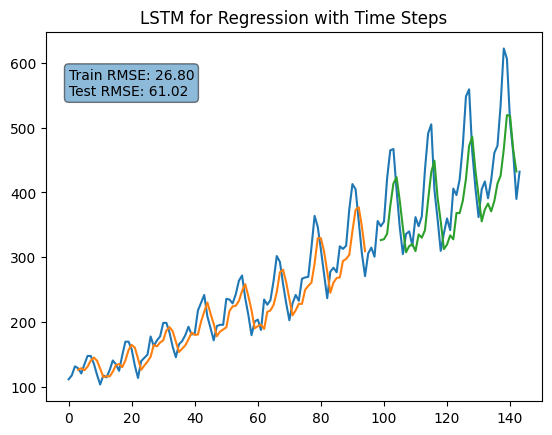

In [92]:
train3RMSE = 'Train RMSE: %.2f' % (train3Score)
test3RMSE = 'Test RMSE: %.2f' % (test3Score)

# shifts train predictions for plotting
train3PredictPlot = np.empty_like(airlines)
train3PredictPlot[:, :] = np.nan
train3PredictPlot[look_back3:len(train3Predict)+look_back3, :] = train3Predict
# shifts test predictions for plotting
test3PredictPlot = np.empty_like(airlines)
test3PredictPlot[:, :] = np.nan
test3PredictPlot[len(train3Predict)+(look_back3*2)+1:len(airlines)-1, :] = test3Predict

# plots baseline and predictions
plt.plot(scaler.inverse_transform(airlines))
plt.plot(train3PredictPlot)
plt.plot(test3PredictPlot)
plt.title('LSTM for Regression with Time Steps')
props = dict(boxstyle='round', alpha=0.5)
plt.text(x=0, y=550, s=(train3RMSE + '\n' + test3RMSE), 
        bbox=props)
plt.show()

#### LSTM for Regression With Memory Between Batches

In [93]:
look_back4 = 3
train4X, train4Y = configure_dataset(train, look_back4)
test4X, test4Y = configure_dataset(test, look_back4)

# the LSTM network expects the input to be structured [samples, time steps, features]
train4X = np.reshape(train4X, (train4X.shape[0], train4X.shape[1], 1))
test4X = np.reshape(test4X, (test4X.shape[0], test4X.shape[1], 1))

# creates and trains the LSTM network
batch_size = 1
reg4_model = Sequential()
reg4_model.add(LSTM(4, batch_input_shape=(batch_size, look_back4, 1), stateful=True))
reg4_model.add(Dense(1))
reg4_model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	reg4_model.fit(train4X, train4Y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	reg4_model.reset_states()

92/92 - 1s - loss: 0.0036 - 1s/epoch - 12ms/step
92/92 - 0s - loss: 0.0052 - 111ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0044 - 118ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0041 - 115ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0039 - 111ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0038 - 105ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0037 - 117ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0037 - 112ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0036 - 113ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0036 - 121ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0036 - 113ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0035 - 121ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0035 - 116ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0034 - 115ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0034 - 121ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0033 - 153ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0033 - 141ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0032 - 114ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0032 - 114ms/epoch - 1ms/step
92/92 - 0s - loss: 0.0031 - 110ms

In [94]:
# makes predictions
train4Predict = reg4_model.predict(train4X, batch_size=batch_size)
reg4_model.reset_states()
test4Predict = reg4_model.predict(test4X, batch_size=batch_size)

# inverts predictions
train4Predict = scaler.inverse_transform(train4Predict)
train4Y = scaler.inverse_transform([train4Y])
test4Predict = scaler.inverse_transform(test4Predict)
test4Y = scaler.inverse_transform([test4Y])

# calculates root mean squared error
train4Score = np.sqrt(mean_squared_error(train4Y[0], train4Predict[:,0]))
test4Score = np.sqrt(mean_squared_error(test4Y[0], test4Predict[:,0]))

print('Train Score: %.2f RMSE' % (train4Score))
print('Test Score: %.2f RMSE' % (test4Score))

44/44 [==============================] - 0s 819us/step
Train Score: 20.99 RMSE
Test Score: 61.58 RMSE


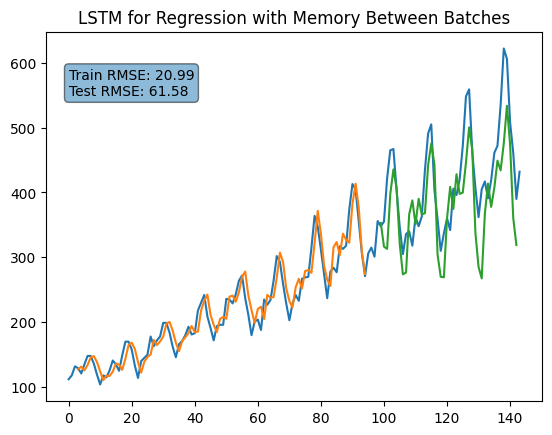

In [95]:
train4RMSE = 'Train RMSE: %.2f' % (train4Score)
test4RMSE = 'Test RMSE: %.2f' % (test4Score)

# shifts train predictions for plotting
train4PredictPlot = np.empty_like(airlines)
train4PredictPlot[:, :] = np.nan
train4PredictPlot[look_back4:len(train4Predict)+look_back4, :] = train4Predict
# shifts test predictions for plotting
test4PredictPlot = np.empty_like(airlines)
test4PredictPlot[:, :] = np.nan
test4PredictPlot[len(train4Predict)+(look_back4*2)+1:len(airlines)-1, :] = test4Predict

# plots baseline and predictions
plt.plot(scaler.inverse_transform(airlines))
plt.plot(train4PredictPlot)
plt.plot(test4PredictPlot)
plt.title('LSTM for Regression with Memory Between Batches')
props = dict(boxstyle='round', alpha=0.5)
plt.text(x=0, y=550, s=(train4RMSE + '\n' + test4RMSE), 
        bbox=props)
plt.show()

#### Stacked LSTMs for Regression With Memory Between Batches

In [96]:
look_back5 = 3
train5X, train5Y = configure_dataset(train, look_back5)
test5X, test5Y = configure_dataset(test, look_back5)

# the LSTM network expects the input to be structured [samples, time steps, features]
train5X = np.reshape(train5X, (train5X.shape[0], train5X.shape[1], 1))
test5X = np.reshape(test5X, (test5X.shape[0], test5X.shape[1], 1))

# creates and trains the LSTM network
batch_size = 1
reg5_model = Sequential()
reg5_model.add(LSTM(4, batch_input_shape=(batch_size, look_back5, 1), 
					stateful=True, return_sequences=True))
reg5_model.add(LSTM(4, batch_input_shape=(batch_size, look_back5, 1), stateful=True))
reg5_model.add(Dense(1))
reg5_model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	reg5_model.fit(train5X, train5Y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	reg5_model.reset_states()

92/92 - 2s - loss: 0.0053 - 2s/epoch - 23ms/step
92/92 - 0s - loss: 0.0069 - 195ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0060 - 187ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 320ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0057 - 226ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 191ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 190ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 183ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 195ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 231ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0057 - 197ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 235ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0057 - 236ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0057 - 230ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0057 - 217ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 233ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0057 - 201ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 215ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 177ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0057 - 196ms

In [97]:
# makes predictions
train5Predict = reg5_model.predict(train5X, batch_size=batch_size)
reg5_model.reset_states()
test5Predict = reg5_model.predict(test5X, batch_size=batch_size)

# inverts predictions
train5Predict = scaler.inverse_transform(train5Predict)
train5Y = scaler.inverse_transform([train5Y])
test5Predict = scaler.inverse_transform(test5Predict)
test5Y = scaler.inverse_transform([test5Y])

# calculates root mean squared error
train5Score = np.sqrt(mean_squared_error(train5Y[0], train5Predict[:,0]))
test5Score = np.sqrt(mean_squared_error(test5Y[0], test5Predict[:,0]))

print('Train Score: %.2f RMSE' % (train5Score))
print('Test Score: %.2f RMSE' % (test5Score))

44/44 [==============================] - 0s 1ms/step
Train Score: 20.01 RMSE
Test Score: 58.06 RMSE


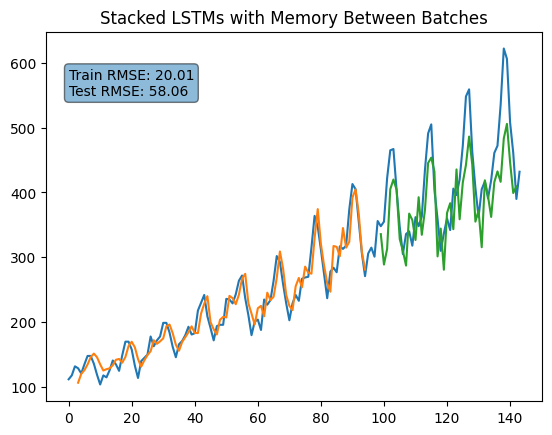

In [98]:
train5RMSE = 'Train RMSE: %.2f' % (train5Score)
test5RMSE = 'Test RMSE: %.2f' % (test5Score)

# shifts train predictions for plotting
train5PredictPlot = np.empty_like(airlines)
train5PredictPlot[:, :] = np.nan
train5PredictPlot[look_back5:len(train5Predict)+look_back5, :] = train5Predict
# shifts test predictions for plotting
test5PredictPlot = np.empty_like(airlines)
test5PredictPlot[:, :] = np.nan
test5PredictPlot[len(train5Predict)+(look_back5*2)+1:len(airlines)-1, :] = test5Predict

# plots baseline and predictions
plt.plot(scaler.inverse_transform(airlines))
plt.plot(train5PredictPlot)
plt.plot(test5PredictPlot)
plt.title('Stacked LSTMs with Memory Between Batches')
props = dict(boxstyle='round', alpha=0.5)
plt.text(x=0, y=550, s=(train5RMSE + '\n' + test5RMSE), 
        bbox=props)
plt.show()